In [1]:
import os
import numpy as np
from osgeo import gdal
import flopy
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt
from flopy.mf6.utils.reference import SpatialReference
import shapefile as shp
from flopy.utils import Raster
import flopy.utils.binaryfile as bf
import time
from scipy import interpolate
import scipy
from matplotlib import colors
import vtk
from flopy.export import vtk



c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarnin

Customized functions are integrated in the mod_utils.py library

In [2]:
import mod_utils
import importlib
importlib.reload(mod_utils)

<module 'mod_utils' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\Groundwater model\\Modflow\\mod_utils.py'>

Geometry input data

In [3]:
# Geometry
geometry_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\Groundwater model\\Inputs\\Marylidia_data\\DEM\\DEM"
shp_Gondebeek_path = os.path.join(geometry_path,"Catchment_Gondebeek_v2.shp")
raster_DEM_path= os.path.join(geometry_path,'DEM_Gondebeek.asc')
raster_A100t_path = os.path.join(geometry_path,'A0100_t.asc')
raster_Paniseliaan_Brusseliaan_Aquifer_path=os.path.join(geometry_path,'A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc')
raster_Paniseliaan_Aquitard_path= os.path.join(geometry_path,'A0700_Paniseliaan_Aquitard.asc')    
raster_eperiaan_Aquifer_path= os.path.join(geometry_path,'A0800_Leperiaan_Aquifer.asc')    

The main working directory and model directory are defined

In [4]:
modelname = 'Gondebeek'
model_dir = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\Groundwater model\\Modflow"

General geometrical aspects of the model are defined

In [5]:
# Load shape
shp_obj = shp.Reader(shp_Gondebeek_path)

# Read shape
feature = shp_obj.shapeRecords()[0]

# Domain extension
bbox = feature.shape.bbox
Lx = -(bbox[0]-bbox[2]) #m
Ly = -(bbox[1]-bbox[3]) #m

# Horizontal discretization
delr = 100
delc = 100

# Number of model rows, and cols
nrow = Ly / delr
ncol = Lx / delc

# Actualizar nrow y ncol
nrow = int(np.round(nrow+.5))
ncol = int(np.round(ncol+.5))

# Actualizar Lx y Ly
Ly = nrow*delr
Lx = ncol*delc

# Origins round to left and up
xul = int(bbox[0]//100*100)
yul = int((bbox[3])//100*100+100)

# Number of layers between guide layers
gls_lays = np.array([1,1,1,1,1])

# Total N of layers are calculated
nlay = gls_lays.sum()

Guide layer elevations are loaded and interpolated to the model grid, including top later DEM

This Python function, ```interpolate_to_grid```, is designed to interpolate data from a set of files to a model grid using the natural neighbor method:

1. **Function Signature:**
    `interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc, base_layer=None, skiprows=None)`

2. **Parameters:**
    - `file_list`: A list of input files.
    - `xul`, `yul`: The upper left coordinates of the model grid.
    - `nrow`, `ncol`: The number of rows and columns in the model grid.
    - `delr`, `delc`: The row and column spacing in the model grid.
    - `base_layer`: An optional layer that defines the base of the model.
    - `skiprows`: The number of rows to skip in the file.

3. **Process:**
    - The function first generates a model grid of (x, y) coordinates.
    - It then initializes an array to hold the interpolated data.
    - If a base layer is provided, it is added to the interpolated array.
    - The function then loops over each file in the file list.
        - It opens each file and reads its lines.
        - It gathers the characteristics of the asc file from the first 6 lines.
        - It loads the data from the asc file into a grid.
        - It generates a grid of (x, y) coordinates for the asc file.
        - It uses the `griddata` function from the `scipy.interpolate` module to interpolate the data from the asc grid to the model grid.
        - It then loops over each cell in the model grid, checking if the interpolated data is less than or equal to 0. If it is, it sets the cell value to the value from the previous layer minus 1. Otherwise, it sets the cell value to the interpolated data.

4. **Return:**
    - The function returns a 3D array with the interpolated data.

In [6]:
file_list = [raster_DEM_path,raster_A100t_path,raster_Paniseliaan_Brusseliaan_Aquifer_path,raster_Paniseliaan_Aquitard_path,raster_eperiaan_Aquifer_path]

interp_elevs = mod_utils.interpolate_to_grid(file_list,xul,yul,nrow,ncol,delr,delc,base_layer=100,skiprows=6)

Guide layer elevations are corrected so they do not cross between each other

1. **Function Signature:**
    `check_layer_elevs(elev_array, threshold=None)`

2. **Parameters:**
    - `elev_array`: A 3D array containing the layer elevation information.
    - `threshold`: An optional parameter that specifies the elevation difference to be assigned if an overlapping layer is encountered. The default value is 0.1.

3. **Process:**
    - The function first checks if a threshold is provided. If not, it sets the threshold to 0.1.
    - It then gets the dimensions of the 3D array.
    - The function loops over each layer in the array (except the first one), and for each cell in each layer, it calculates the difference in elevation between the current layer and the one above it.
    - If the difference is less than or equal to 0 (indicating an overlap), it adjusts the elevation of the current cell to be lower than the cell above it by the specified threshold.

4. **Return:**
    - The function returns the adjusted 3D array.

In [7]:
interp_elevs = mod_utils.check_layer_elevs(interp_elevs,1.0)

Botm and topm array are generated

In [8]:
botm = np.zeros((nlay,nrow,ncol),dtype=float)
botm = mod_utils.fill_botm_array(botm,interp_elevs,gls_lays)
topm = mod_utils.fill_topm_array(botm,interp_elevs,gls_lays)

In [9]:

interp_elevs

array([[[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        ...,
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]],

       [[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        ...,
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]],

       [[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
        [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
    

Temporal discretization

In [10]:
# Fecha inicial y final
year_0 = 2015; month_0 = 1; day_0 = 1 
year_F = 2016; month_F = 1; day_F = 1 

SP = mod_utils.Constru_SP(year_0, month_0, day_0, year_F, month_F, day_F, scale='d', n_scale=1)
perlen, fecha_inicialSP, fecha_finalSP, nstp, tsmult, steady = SP
nper = len(perlen)

Basic packages are created

In [11]:
mf2005_exe = os.path.join('MODFLOW-NWT.exe')  # Path to MODFLOW-2005 NWT executable
#noflow = mod_utils.active_cell(sim,shp_obj)
sim = flopy.modflow.Modflow(modelname=modelname, model_ws=model_dir,
                          version='mf2005', exe_name=mf2005_exe,
                          structured=True)
                          
                          
dis = flopy.modflow.ModflowDis(sim, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=interp_elevs[0], botm=botm,
                              xul=xul, yul=yul, nper=nper,steady=steady,
                               perlen=perlen,nstp=nstp,tsmult=tsmult)

lpf = flopy.modflow.ModflowLpf(sim, ipakcb=50, hk=500, laytyp=4,layvka=1)
# Write BAS package
bas = flopy.modflow.ModflowBas(sim, strt=interp_elevs[0])
# Convert the Util3d object to a numpy array
sim.write_input()
noflow = mod_utils.active_cell(sim,shp_obj)
bas = flopy.modflow.ModflowBas(sim, strt=interp_elevs[0],ibound=noflow)
botm_array = dis.botm.array

# Change negative elevations to zero
botm_array[botm_array < 0] = 0

# Convert the numpy array back to a Util3d object
dis.botm = flopy.utils.Util3d(sim, botm_array.shape, np.float32, botm_array, name='botm', locat=dis.unit_number[0])
# Write the modified DIS package back to the model

# Convert the Util2d object to a numpy array
top_array = dis.top.array

# Change negative top elevations to zero
top_array[top_array < 0] = 0

# Convert the numpy array back to a Util2d object
dis.top = flopy.utils.Util2d(sim, top_array.shape, np.float32, top_array, name='top', locat=dis.unit_number[0])

bas.write_file()

sim.write_input()
dis.check()

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:658: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:667: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(



DIS PACKAGE DATA VALIDATION:
  1515 Errors:
    1232 instances of thin cells (less than checker threshold of 1.0)
    283 instances of zero or negative thickness

  Checks that passed:
    nan values in top array
    nan values in bottom array



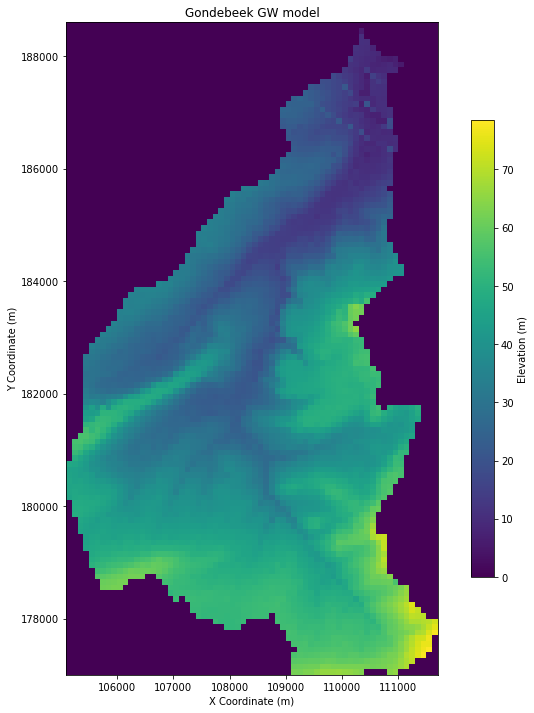

In [15]:

# Get the top layer of the model
top_layer = sim.dis.top.array

# Define the minimum and maximum values for the colorbar
vmin, vmax = top_layer.min(), top_layer.max()

# Create a figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a map of the model
modelmap = flopy.plot.PlotMapView(model=sim)

# Plot the top layer of the model
quadmesh = modelmap.plot_array(top_layer, vmin=vmin, vmax=vmax)

# Plot the grid and inactive cells
#linecollection = modelmap.plot_grid()
#quadmesh = modelmap.plot_ibound(ibound=noflow, color_noflow='cyan')

# Add a colorbar with a label
cbar = plt.colorbar(quadmesh, shrink=0.7)
cbar.set_label('Elevation (m)')

# Add labels to the x and y axes
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')

# Add a title
plt.title("Gondebeek GW model")

# Save the plot as a PNG file
plt.savefig('Gondebeek_GW_model.png')

# Show the plot
plt.show()


Export grid to VTK

In [13]:

# Get the modelgrid from the model
modelgrid = sim.modelgrid

# Create a vtk object
vtkobj = flopy.export.vtk.Vtk(sim, modelgrid=modelgrid, vertical_exageration=10)
# Add the bottom elevation of each layer to the VTK object
vtkobj.add_array(sim.dis.botm.array, "botm")

# Assuming 'hk' is your hydraulic conductivity array
hk = sim.lpf.hk.array

# Add the hydraulic conductivity to the VTK object
vtkobj.add_array(hk, "HydraulicConductivity")

# Add the noflow cells to the VTK object
vtkobj.add_array(noflow, "NoFlow")

# Write the vtk object to file
vtkobj.write("model2.vtk")